[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bradley-Buchner/worm_synergy/blob/master/notebooks/model_exploration.ipynb)

# Synergy Graph Transformer (GT) Model Exploration
In this notebook...  for the Worm Synergy GT model, designed to predict the likelihood that two genes determine lifespan synergistically

In [ ]:
!git clone https://github.com/Bradley-Buchner/worm_synergy.git

In [ ]:
%%bash
# pip install -qr requirements.txt

# NOTE: you may now need to restart your kernel

In [232]:
import pickle
import importlib

import model
from model.preprocessing import *
from model.models import *
from model.utils import *

importlib.reload(model.preprocessing)
importlib.reload(model.models)
importlib.reload(model.utils)


<module 'model.utils' from '/Users/bradleybuchner/Desktop/grad_school/research/aging_project/worm_synergy/model/utils.py'>

In [218]:
data = torch.load('../data/worm_synergy_pyg_data_demo_processed.pt', weights_only=False)
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
data.to(device)

with open("../data/perturbation2idx.pkl", "rb") as f:
    perturbation2idx = pickle.load(f)

with open("../data/node2id.pkl", 'rb') as f:
    node2id = pickle.load(f)

with open("../data/id2node.pkl", 'rb') as f:
    id2node = pickle.load(f)

subgraph_data = torch.load('../data/synergy_gt_subgraphs.pt', weights_only=False)

out_degree = degree(data.edge_index[0], num_nodes=data.num_nodes)
in_degree = degree(data.edge_index[1], num_nodes=data.num_nodes)
max_degree = torch.max(torch.cat([in_degree, out_degree], dim=0)).item()

spd_filepath = "../data/graph_transformer/spd_matrix.pt"
spd_tensor = torch.load(spd_filepath, weights_only=False)

params = {
    'sum_node_features': True,
    'use_pretrained_gene_embs': False,
    'fine_tune_gene_emb': False,
    'fine_tune_ont_emb': False,
    'randomize_labels': False,
    'max_spd': spd_tensor.max().item(),
    'num_degree_bins': 5,
    'dropout_p': 0.1,
    'd_model': 8,
    'num_heads': 2,
    'num_layers': 6
}

model_loaded = SynergyGT(
    graph_data=data,
    params=params
).to(device)
model_loaded.load_state_dict(torch.load('../data/final_synergy_gt_model_state_dict_122825_8d_6l.pth', map_location=device, weights_only=False))
model_loaded.eval()
print("--- Loaded Model Architecture ---")
print(model_loaded)

--- Loaded Model Architecture ---
SynergyGT(
  (node_identity_embedding): Embedding(11494, 8, padding_idx=11493)
  (dist_uv_embedding): Embedding(11, 8)
  (in_degree_embedding): Embedding(6, 8)
  (out_degree_embedding): Embedding(6, 8)
  (lifespan_dist_embedding): Embedding(7, 8, padding_idx=6)
  (perturbation_embedding): Embedding(4, 8, padding_idx=3)
  (pairwise_dist_embedding): Embedding(11, 2, padding_idx=10)
  (edge_type_embedding): Embedding(3, 2, padding_idx=2)
  (mutual_interactor_bias_emb): Embedding(2, 2)
  (dist_uv_bias_embedding): Embedding(11, 2)
  (value_projections): ModuleDict(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=8, bias=True)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x RelationalGTEncoderLayer(
      (value_projections): ModuleDict(
        (0): Linear(in_features=8, out_features=8, bias=True)
        (1): Linear(in_features=8, out_features

## Pair exploration
For any pair of genes get...
* predicted likelihoods of antagonistic, additive, and synergistic interactions
* a summary of their combined, one-hop subgraph that the model uses to make predictions

Replace the gene names below with any two genes of interest

In [219]:
gene_u = "age-1"
gene_v = "lgc-26"
gene_u_id = node2id[gene_u]
gene_v_id = node2id[gene_v]
inference_pairs = [(gene_u_id, gene_v_id)]

pre_configs = {
    'max_spd': spd_tensor.max().item(),
    'max_dist_uv': spd_tensor.max().item(),
    'k_hop': 1,
    'sampling_mode': 'union',
    'target_subgraph_size': 0,
    'max_in_degree': max_degree,
    'max_out_degree': max_degree,
    'num_degree_bins': 5,
    'attributes_dir': '../data/graph_transformer',
    'output_path': None,
    'device': 'cpu'
}

pert_a_max = data.pair_pert_group_index[1].max().item()
pert_b_max = data.pair_pert_group_index[3].max().item()
pert_padding = max(pert_a_max, pert_b_max) + 1
collate_fn_configs = {
    'node_ids': data.num_nodes,
    'node_perturbations': pert_padding,
    'in_degree': max_degree + 1,
    'out_degree': max_degree + 1,
    'dist_to_u': spd_tensor.max().item() + 1,
    'dist_to_v': spd_tensor.max().item() + 1,
    'pairwise_dist': spd_tensor.max().item() + 1,
    'adj_matrix': data.edge_type.max().item() + 1,
    'average_edge_type_encoding': data.edge_type.max().item() + 1,
    'lifespan_dist': data.lifespan_dist.max().item() + 1
}

inference_loader, inference_subgraph = get_loader_inference(data, inference_pairs, preprocessor_fn=preprocess_and_save_subgraphs_graphormer, preprocessor_fn_configs=pre_configs, dataset_cls=PairSubgraphDataset, collate_fn=graphormer_collate_fn, collate_fn_configs=collate_fn_configs, batch_size=32)


--- Initializing Inference for 1 Pair(s) ---
--- Starting Subgraph Pre-processing ---
Mode: union, Target Augmentation Size: 0, Device: cpu
Loading pre-computed attributes from ../data/graph_transformer...

Processing 1 pairs...


Building Subgraphs: 100%|██████████| 1/1 [00:00<00:00, 168.64it/s]

--- Pre-processing finished successfully! Returning 1 samples. ---


### Gene-pair predictions and subgraph
*Note: predictions are made using the most common perturbation combination: gene U knockdown + gene V knockout*

MC Dropout Sampling: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

--- Antagonistic Interaction Statistics ---
MAP Estimate: 0.2444
95% CI:       [0.2281, 0.2789]
Mean (μ):     0.2473

--- Additive Interaction Statistics ---
MAP Estimate: 0.3711
95% CI:       [0.2998, 0.4501]
Mean (μ):     0.3680

--- Synergistic Interaction Statistics ---
MAP Estimate: 0.3747
95% CI:       [0.3103, 0.4532]
Mean (μ):     0.3848



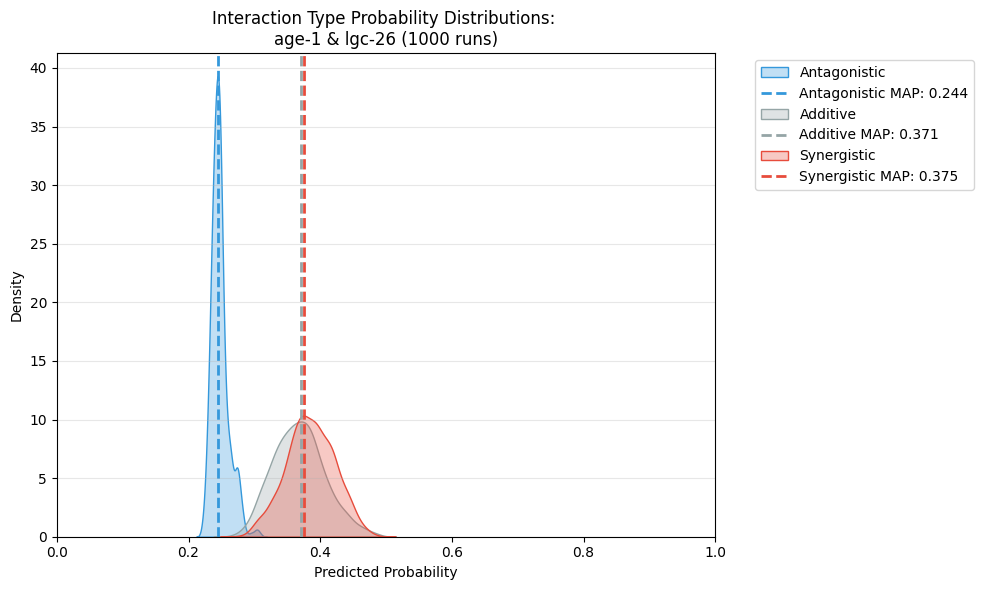

In [220]:
# Get a distribution of predictions for the gene pair using MC dropout sampling
samples = 1000
results = predict_with_mc_dropout(model_loaded, inference_loader, num_samples=samples, device=device)

# Visualize results for the first pair in the loader
plot_uncertainty_densities(results[0], pair_name=f"\n{gene_u} & {gene_v} ({samples} runs)")

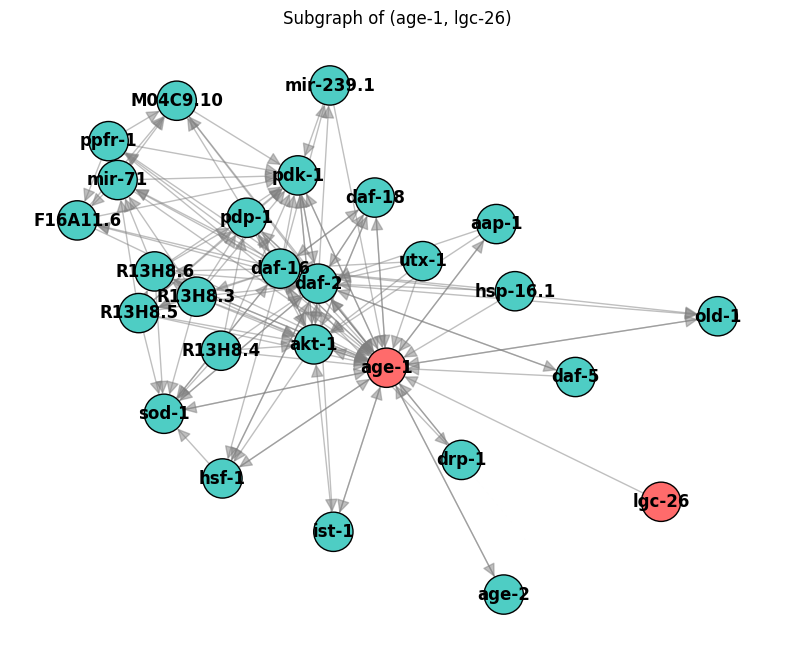

=== Subgraph Summary (age-1 & lgc-26) ===

Hop distance between nodes: 1   (1 => nodes interact directly)

Aging distance (lifespan_dist) - Gene U: 0, Gene V: 0   (0 => is a known lifespan gene, 1 => interacts with a known lifespan gene)

=== Subgraph Edge Summary ===
Total interactions/edges: 135
- Genetic (Type 0): 89 (65.9%)
- Regulatory (Type 1): 40 (29.6%)
- Physical (Type 2): 6 (4.4%)


In [207]:
# Plot the subgraph for the gene pair of interest
plot_subgraph_sample(inference_subgraph, data, id2node_dict=id2node)

# Get summary statistics for the pair's subgraph
analyze_subgraph_sample(inference_subgraph, id2node_dict=id2node)

## Single-gene exploration
take any gene and show...
* its graph data (in degree, out degree, edge type breakdown, aging distance, etc.)
* its experimental data (if it exists)
* its predicted % of antagonistic, additive, or synergistic interactions (sample all possible partners)
* its predicted most synergistic partners (under a certain perturbation scheme)
* its average model prediction confidence

### Single-gene data summary

In [208]:
gene_name = "rsks-1"
gene_id = node2id[gene_name]

single_gene_summary(gene_id, data, id2node)

=== Summary for Gene: rsks-1 (ID: 3140) ===
- Centrality: In-Degree = 7.0, Out-Degree = 23.0
- Interaction Types (Total: 30):
  * Genetic:    7 (23.3%)
  * Regulatory: 9 (30.0%)
  * Physical:   14 (46.7%)
- Known Lifespan Association: YES
- Neighbors: 29 unique neighbors, 5 are lifespan genes
- Appears in Experimental Data: Yes
- Experimental Details:
  * Involved in 24 unique tested pairs
  * Avg. Interaction Distribution [Antag / Neither / Synerg]:
    [0.234 / 0.485 / 0.281]

  * Full Experiment List (w/ smoothed interaction type frequencies):
    Experiment                               | Distribution [A/N/S]
    -----------------------------------------------------------------
    daf-2(ko) + rsks-1(ko)                   | [0.059, 0.059, 0.882]
    daf-16(kd) + rsks-1(ko)                  | [0.143, 0.714, 0.143]
    daf-16(ko) + rsks-1(ko)                  | [0.200, 0.600, 0.200]
    hsf-1(kd) + rsks-1(ko)                   | [0.100, 0.500, 0.400]
    hsf-1(ko) + rsks-1(ko)       

### Single-gene model predictions

In [209]:
# Get all partners and build list of pair tuples
all_inference_pairs = []
for id in list(id2node.keys()):
    if id != gene_id:
        tuple = (gene_id, id)
        all_inference_pairs.append(tuple)

all_inference_loader, all_inference_subgraphs = get_loader_inference(data, all_inference_pairs, preprocessor_fn=preprocess_and_save_subgraphs_graphormer, preprocessor_fn_configs=pre_configs, dataset_cls=PairSubgraphDataset, collate_fn=graphormer_collate_fn, collate_fn_configs=collate_fn_configs, batch_size=32)



--- Initializing Inference for 11492 Pair(s) ---
--- Starting Subgraph Pre-processing ---
Mode: union, Target Augmentation Size: 0, Device: cpu
Loading pre-computed attributes from ../data/graph_transformer...

Processing 11492 pairs...


Building Subgraphs: 100%|██████████| 11492/11492 [00:25<00:00, 449.05it/s]


--- Pre-processing finished successfully! Returning 11492 samples. ---


In [233]:
# Get predictions for all possible pairs including the gene of interest
predictions = get_predictions_synergy_model(model_loaded, all_inference_loader, label_name=None, device=device)

# Summarize predictions for the gene of interest
single_gene_predictions(predictions, id2node, gene_id, top_n=10)

Eval: 100%|██████████| 360/360 [00:17<00:00, 20.15it/s] 


=== Model Predictions for Gene: rsks-1 (ID: 3140) ===
- Evaluation Details:
  * Total Pairs Evaluated: 11492
  * Avg. Predicted Distribution [Antag / Addit / Synerg]:
    [0.237 / 0.464 / 0.298]

  * Top 10 most synergistic double mutants:
    Mutant                                        | Synergistic Prob.   
    ----------------------------------------------------------------------
    rsks-1(kd) + cst-1(ko)                        | 0.485
    rsks-1(kd) + Y94H6A.10(ko)                    | 0.483
    rsks-1(kd) + vit-1(ko)                        | 0.480
    rsks-1(kd) + dsc-4(ko)                        | 0.478
    rsks-1(kd) + fezf-1(ko)                       | 0.477
    rsks-1(kd) + snr-2(ko)                        | 0.474
    rsks-1(kd) + trmt-10C.2(ko)                   | 0.474
    rsks-1(kd) + efn-4(ko)                        | 0.473
    rsks-1(kd) + mmad-1(ko)                       | 0.472
    rsks-1(kd) + mrpl-24(ko)                      | 0.467


## Open exploration
* show gene pairs most likely to have a synergistic effect on lifespan (under a certain perturbation scheme)